# Understanding neural circuit and dynamics with recurrent neural networks
(First draft: Po-Chen Kuo 06.21.2024)
- task trained RNNs
- actor-critic RNNs solving dynamic foraging
- visualize RNN acticities using PCA
- dynamical systems analysis of RNN

In [1]:
# import
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
# import torch

## 1. Task trained recurrent neural network

### TODO: intro paragraph on task-trained RNNs

### Task-trained RNNs with reinforcement learning
- policy gradient method
- actor-critic algorithm

## 2. Actor-critic RNNs solving dynamic foraging

As our goals in this tutorial is to analyze RNN circuit and dynamics, here we provide RNNs readily trained to solve the dynamic foraging task. 
We will first look at the behavior from example sessions.

On each trial, the RNN receives the action (0/1 indicating left/right) and reward (0 or 1) from the previous trial as input, integrates this input with its hidden states, and generates an action (0/1 indicating left/right) as output

In [2]:
# define hyper-parameters
action_dim = 2
total_trials = 400

rnn_hidden_dim = 64

In [3]:
# load example sessions
with open(f'./utils/info_testing_set.pickle', 'rb') as f:
    info_testing_set = pickle.load(f)

actions_testing_set = np.load('./utils/actions_testing_set.npy')
rewards_testing_set = np.load('./utils/rewards_testing_set.npy')
a1_probs_testing_set = np.load('./utils/a1_probs_testing_set.npy')
actor_hidden_states_testing_set = np.load('./utils/actor_hidden_states_testing_set.npy', )

In [4]:
# select the first example session
example_session_id = 0
info = info_testing_set[example_session_id]
actions = actions_testing_set[example_session_id]
rewards = rewards_testing_set[example_session_id]
a1_probs = a1_probs_testing_set[example_session_id]
actor_hidden_states = actor_hidden_states_testing_set[example_session_id]

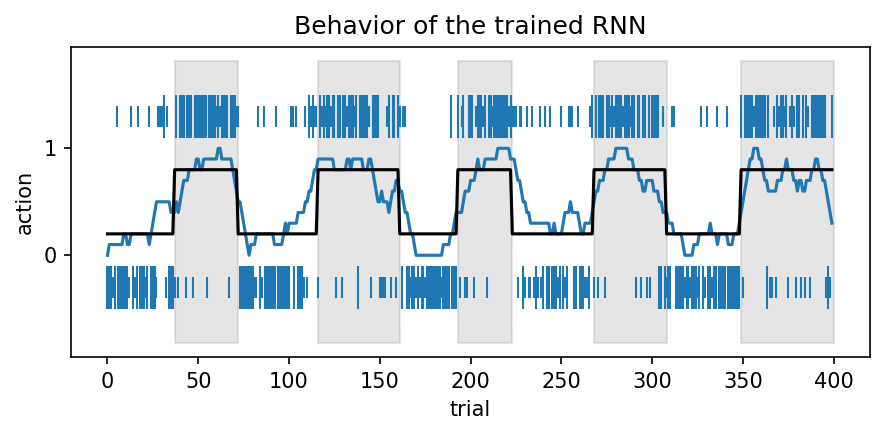

In [5]:
# plot the behavior from example session

def shading_blocks(ax, info):

    y_min, y_max = ax.get_ylim()
    block_start = 0
    for block_ind in range(len(info['block_lens'])):
        if block_ind % 2 == 1:
            ax.fill_between(
                [block_start, block_start+info['block_lens'][block_ind]],
                y_min, y_max,
                color='gray', alpha=0.2
            )
        block_start += info['block_lens'][block_ind]

        
fig, ax = plt.subplots(1,1, figsize=(6, 3), dpi=150)
ax.set_title(f'Behavior of the trained RNN')

# event raster
events = []
for act in range(action_dim):
    # 0: action 0, 1: action 1
    for rew in [0, 1]:
        events_act_rew = np.where(
            (actions==act) & (rewards==rew))[0]
        events.append(events_act_rew)
line_offsets = [-0.3,-0.3] + [1.3,1.3]
line_lengths = [0.2,0.4] + [0.2,0.4]
ax.eventplot(events, lineoffsets=line_offsets, 
            linelengths=line_lengths, linewidth=1)

# action running average
running_average_window = 10
actions_moving_average = np.convolve(
    np.array(actions), np.ones(running_average_window), mode="same") \
        / running_average_window
ax.plot(
    np.arange(len(actions_moving_average)), 
    actions_moving_average
)

# block reward prob: action 1
# get blocks
rew_prob_a1 = []
for block_idx, block_len in enumerate(info['block_lens']):
    for trial_idx in range(block_len):
        rew_prob_a1.append(info['reward_prob'][block_idx][1])
block_reward_prob_color = 'k'
            
ax.plot(
    np.arange(len(rew_prob_a1)),
    rew_prob_a1, 
    c=block_reward_prob_color
)
shading_blocks(ax, info)

ax.set_xlabel('trial')
ax.set_ylabel('action')
ax.set_yticks([0, 1], [0, 1])

fig.tight_layout()

(0.0, 1.0)

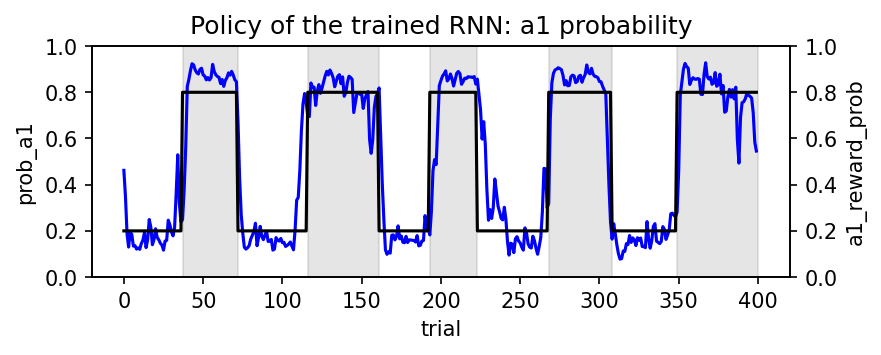

In [6]:
# plot the output: policy or action probability

fig, ax = plt.subplots(1,1, figsize=(6, 2), dpi=150)
ax.set_title(f'Policy of the trained RNN: a1 probability')

colors = ['b']

arr = a1_probs
ax.plot(np.arange(len(arr)), arr, label='prob_a1', color=colors[0])

ax.set_xlabel('trial')
ax.set_ylabel('prob_a1')
ax.set_ylim(0, 1)

shading_blocks(ax, info)

# block reward prob: action 1
ax = ax.twinx()
ax.plot(
    np.arange(len(rew_prob_a1)),
    rew_prob_a1, 
    c=block_reward_prob_color
)
ax.set_ylabel('a1_reward_prob', c=block_reward_prob_color)
ax.tick_params(axis='y', labelcolor=block_reward_prob_color)
ax.set_ylim(0, 1)


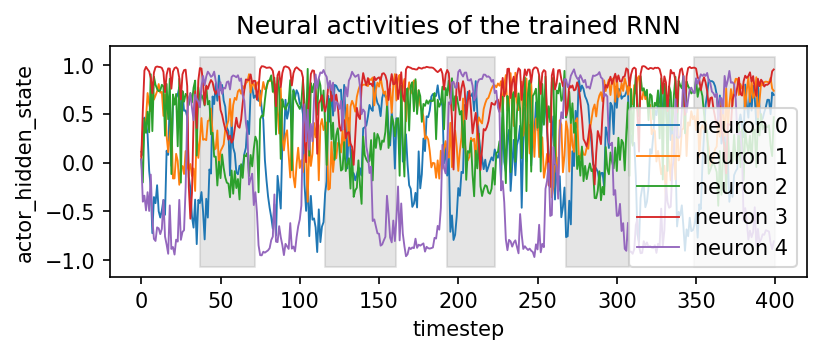

In [7]:
# plot RNN activity
n_hidden_units_plot = 5

fig, ax = plt.subplots(1,1, figsize=(6, 2), dpi=150)
ax.set_title(f'Neural activities of the trained RNN')

for plot_id in range(n_hidden_units_plot):
    arr = actor_hidden_states[:, plot_id]
    ax.plot(arr, lw=0.9, label=f'neuron {plot_id}')

shading_blocks(ax, info)

ax.set_xlabel('timestep')
ax.set_ylabel('actor_hidden_state')
ax.legend()

In [8]:
# EXERCISE: plot the above for another session
# discussion: what's the difference between each session?

## 3. Visualize RNN activities using PCA

To better visualize and understand network dynamics of the trained network, we can apply dimensionality reduction methods to extract relevant dimensions within the high-dimensional neural activity space. 
One example method is principal component analysis (PCA), which captures the dimensions that explain the most variances within our dataset.

In [9]:
# load training set: 20 sessions
with open(f'./utils/info_training_set.pickle', 'rb') as f:
    info_training_set = pickle.load(f)

actions_training_set = np.load('./utils/actions_training_set.npy')
rewards_training_set = np.load('./utils/rewards_training_set.npy')
a1_probs_training_set = np.load('./utils/a1_probs_training_set.npy')
actor_hidden_states_training_set = np.load('./utils/actor_hidden_states_training_set.npy')

In [10]:
# PCA on the training set
from sklearn.decomposition import PCA

num_components = 8

pca_model_actor = PCA(n_components=num_components)
pca_model_actor.fit(actor_hidden_states_training_set.reshape(-1, rnn_hidden_dim))

print(f'PCA explained variance: {pca_model_actor.explained_variance_ratio_}')

PCA explained variance: [0.3633771  0.24029164 0.08248743 0.07456447 0.05349012 0.04326019
 0.02841566 0.02288716]


(0.0, 1.0)

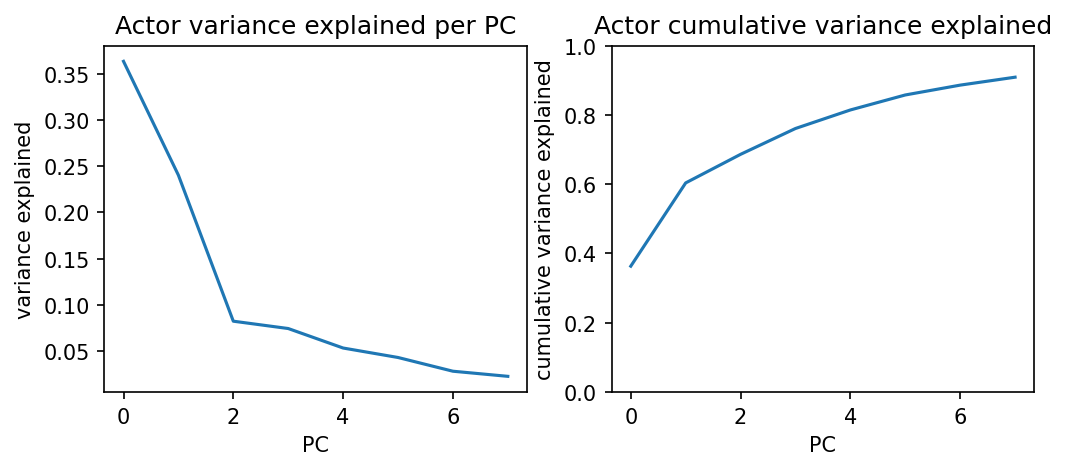

In [11]:
# cumulative variance explained
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), dpi=150)

ax = axs[0]
ax.plot(pca_model_actor.explained_variance_ratio_)
ax.set_title('Actor variance explained per PC')
ax.set_xlabel('PC')
ax.set_ylabel('variance explained')

ax = axs[1]
ax.plot(np.cumsum(pca_model_actor.explained_variance_ratio_))
ax.set_title('Actor cumulative variance explained')
ax.set_xlabel('PC')
ax.set_ylabel('cumulative variance explained')
ax.set_ylim(0, 1)

In [12]:
# transform
transformed_actor_hidden_states_training_set = pca_model_actor.transform(
    actor_hidden_states_training_set.reshape(-1, rnn_hidden_dim))
transformed_actor_hidden_states_training_set = transformed_actor_hidden_states_training_set.reshape(
    -1, total_trials, num_components)

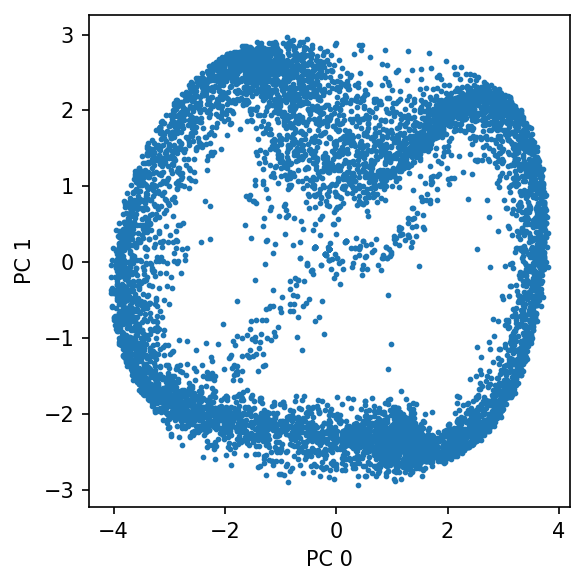

In [13]:
# visualize the first two PCs
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=150)

pc_x = 0
pc_y =1

scatter = ax.scatter(
    transformed_actor_hidden_states_training_set[:, :, pc_x],
    transformed_actor_hidden_states_training_set[:, :, pc_y],
    s=3.0
#     c=a1_probs_all, cmap=cm.bwr,
#     vmin=0, vmax=1,
)

ax.set_xlabel(f'PC {pc_x}')
ax.set_ylabel(f'PC {pc_y}')
# fig.colorbar(scatter, ax=ax)

fig.tight_layout()

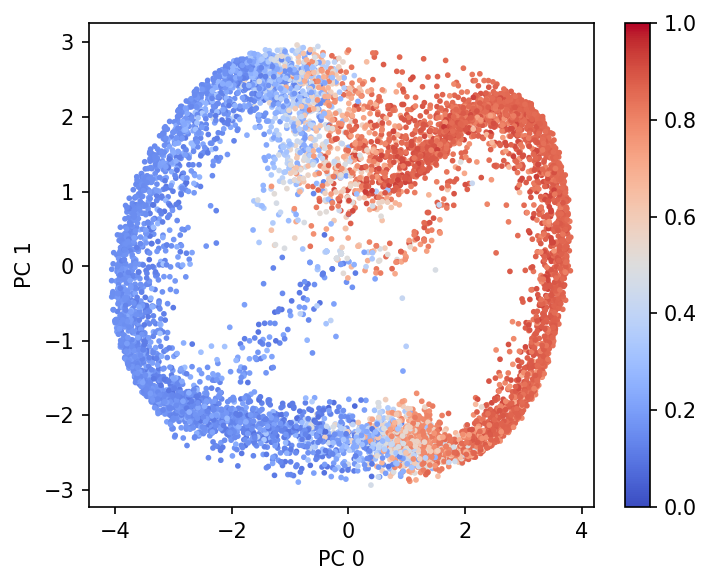

In [44]:
# visualize the first two PCs: color-code by a1_prob
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=150)

pc_x = 0
pc_y =1

scatter = ax.scatter(
    transformed_actor_hidden_states_training_set[:, :, pc_x],
    transformed_actor_hidden_states_training_set[:, :, pc_y],
    s=3.0,
    c=a1_probs_training_set, cmap=cm.coolwarm,
    vmin=0, vmax=1,
)

ax.set_xlabel(f'PC {pc_x}')
ax.set_ylabel(f'PC {pc_y}')
fig.colorbar(scatter, ax=ax)

fig.tight_layout()

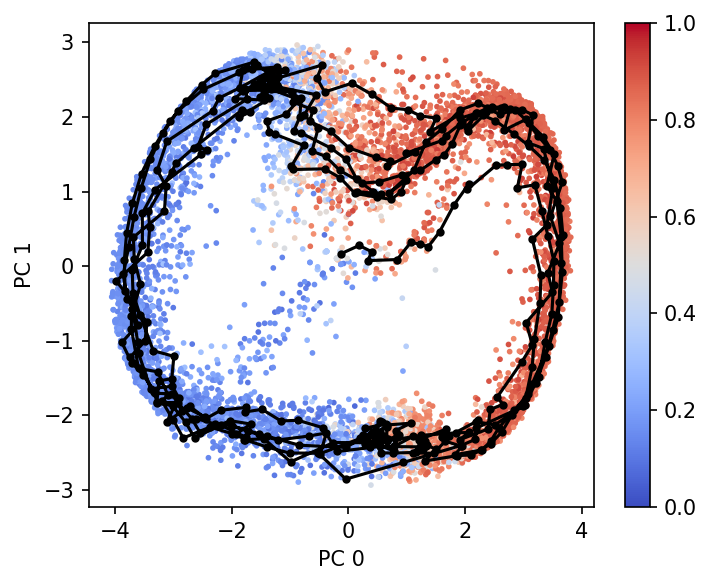

In [45]:
# PCA on the testing set: visualize the first two PCs
# Let's see how one test episode rollsout: again, use the first session in the test set
# recall the test roll out above

# transform the test set first
transformed_actor_hidden_states_testing_set = pca_model_actor.transform(
    actor_hidden_states_training_set.reshape(-1, rnn_hidden_dim))
transformed_actor_hidden_states_testing_set = transformed_actor_hidden_states_testing_set.reshape(
    -1, total_trials, num_components)


# how many steps to visualize
trial_end = 400

fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=150)

pc_x = 0
pc_y =1

scatter = ax.scatter(
    transformed_actor_hidden_states_training_set[:, :, pc_x],
    transformed_actor_hidden_states_training_set[:, :, pc_y],
    s=3.0,
    c=a1_probs_training_set, cmap=cm.coolwarm,
    vmin=0, vmax=1,
)
ax.plot(
    transformed_actor_hidden_states_testing_set[example_session_id, :trial_end, pc_x],
    transformed_actor_hidden_states_testing_set[example_session_id, :trial_end, pc_y],
    color='k', marker='o', ms=3
)

ax.set_xlabel(f'PC {pc_x}')
ax.set_ylabel(f'PC {pc_y}')
fig.colorbar(scatter, ax=ax)

fig.tight_layout()

In [ ]:
# EXERCISE: play with the trial_end parameter above, explore how the RNN activities evolve in this PC space

In [ ]:
# EXERCISE: visualize other PCs, what do you find?

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import imageio
import io

def create_frame(elev, azim, axes_set = [0,1,2], frame = -1):

    if frame > np.shape(transformed_actor_hidden_states_testing_set)[1]:
        frame = np.shape(transformed_actor_hidden_states_testing_set)[1]
        
    fig = plt.figure(figsize=(10, 8), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        transformed_actor_hidden_states_training_set[:, :, axes_set[0]],
        transformed_actor_hidden_states_training_set[:, :, axes_set[1]],
        transformed_actor_hidden_states_training_set[:, :, axes_set[2]],
        s=40.0,
        c=a1_probs_training_set, cmap=cm.coolwarm,
        vmin=0, vmax=1, alpha = .2
    )
    
    ax.plot(
        transformed_actor_hidden_states_testing_set[example_session_id, :frame, axes_set[0]],
        transformed_actor_hidden_states_testing_set[example_session_id, :frame, axes_set[1]],
        transformed_actor_hidden_states_testing_set[example_session_id, :frame, axes_set[2]],
        color='k', alpha = .5,linewidth = 3
    )

    for tw in range(5):
        frametail = np.max(frame - tw,0)
        ax.plot(
            transformed_actor_hidden_states_testing_set[example_session_id, frametail:frame+1, axes_set[0]],
            transformed_actor_hidden_states_testing_set[example_session_id, frametail:frame+1, axes_set[1]],
            transformed_actor_hidden_states_testing_set[example_session_id, frametail:frame+1, axes_set[2]],
            color='k', alpha = .5, linewidth = 10 - tw
        )
    
    ax.plot(
        transformed_actor_hidden_states_testing_set[example_session_id, frame, axes_set[0]],
        transformed_actor_hidden_states_testing_set[example_session_id, frame, axes_set[1]],
        transformed_actor_hidden_states_testing_set[example_session_id, frame, axes_set[2]],
        color='k', marker='o', ms=15, alpha = .8
    )    
    
    ax.plot(
        transformed_actor_hidden_states_testing_set[example_session_id, frame, axes_set[0]],
        transformed_actor_hidden_states_testing_set[example_session_id, frame, axes_set[1]],
        transformed_actor_hidden_states_testing_set[example_session_id, frame, axes_set[2]],
        color=cm.coolwarm(a1_probs_testing_set[example_session_id,frame]), marker='o', ms=10, alpha = .8
    )
    
    ax.set_xlabel('PC '+str(axes_set[0]))
    ax.set_ylabel('PC '+str(axes_set[1]))
    ax.set_zlabel('PC '+str(axes_set[2]))
    
    fig.colorbar(scatter, ax=ax, label='Probability of Licking Right')
    
    ax.view_init(elev=elev, azim=azim)
    ax.grid(False)
    
    fig.tight_layout()
    
    # Save the plot to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    plt.close(fig)
    
    return buf

# Create frames
def make_mov(n_frames = 360,azim_start = 60,axes_set = [0,1,2]):
    frames = []
    for i in range(n_frames):
        # Calculate elevation and azimuth for this frame
        elev = 30 + 30 * np.sin(2 * np.pi * i / n_frames)  # Oscillate between -10 and 50 degrees
        azim = 60+360 * i / n_frames  # Full 360 degree rotation
        
        buf = create_frame(elev, azim, axes_set = axes_set, frame = i)
        frame = imageio.imread(buf)
        frames.append(frame)
    
    # Save as GIF
    axes_set_str = '_'.join(str(x) for x in axes_set)
    imageio.mimsave('rotating_3d_plot_2rotationaxes'+ axes_set_str +'.gif', frames, fps=5)

In [61]:
make_mov(n_frames = 360,azim_start = 60,axes_set = [0,1,2])

/var/folders/rv/bpj1qnwx5lz32q8rr9jxs07h0000gp/T/ipykernel_29981/1522370226.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(buf)


## 4. Dynamical systems analysis of RNN

### Finding approximate fixed points
Here we aim to find approximate fixed points. For a given dynamical system (e.g. the trained RNN),
\begin{align}
    \frac{d\mathbf{x}}{dt} = F(\mathbf{x}),
\end{align}

We can find approximated fixed points by minimizing
\begin{align}
    \mathrm{argmin}_{\mathbf{x}}  q = \frac{1}{2} (F(\mathbf{x}))^2.
\end{align}

Because there are four different input conditions (prev_action, prev_reward) for our task: (0, 1), (0, 0), (1, 0), (1, 1), we can find fixed points of the trained RNN under these conditions respectively.

In [64]:
# Discuss & Issue
# Discuss: Do we want to go through implementation of fixed point finding here? Or just stay conceptual?
# consideration 1: minimization takes a while

# Issue: can't seem to install pytorch in this container yet?

# Proposal: we can go through the steps for fixed point finding conceptually, 
# but leave the implementation to exercise: 
# initialize along the trajecotry/ speculated regions --> minimize q --> 
# save when it meets the pre-defined q threshold

# Hence here I provide pre-computed fixed points, computed with q_threshold=0.001

In [65]:
# load the pre-computed fixed points
with open(f'./utils/fixed_points_per_condition.pickle', 'rb') as f:
    fixed_points_per_condition = pickle.load(f)

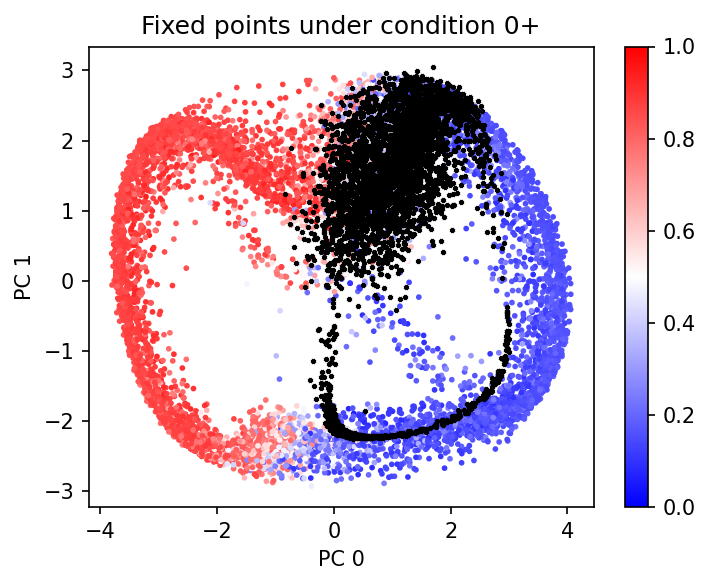

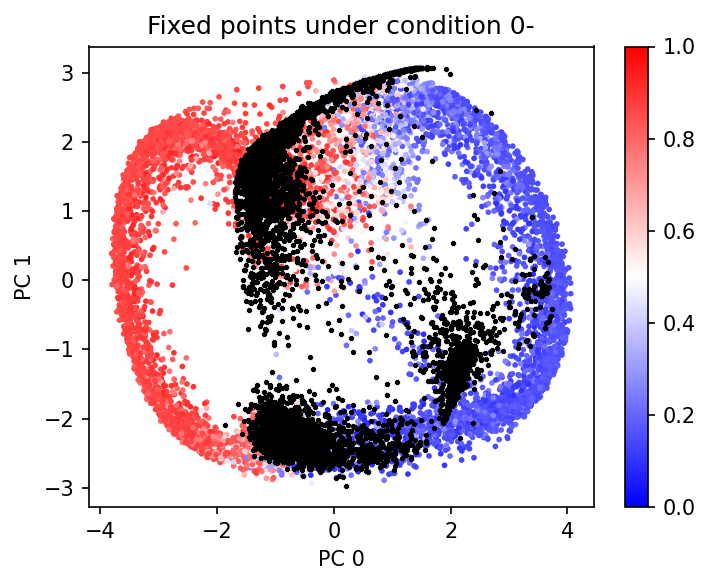

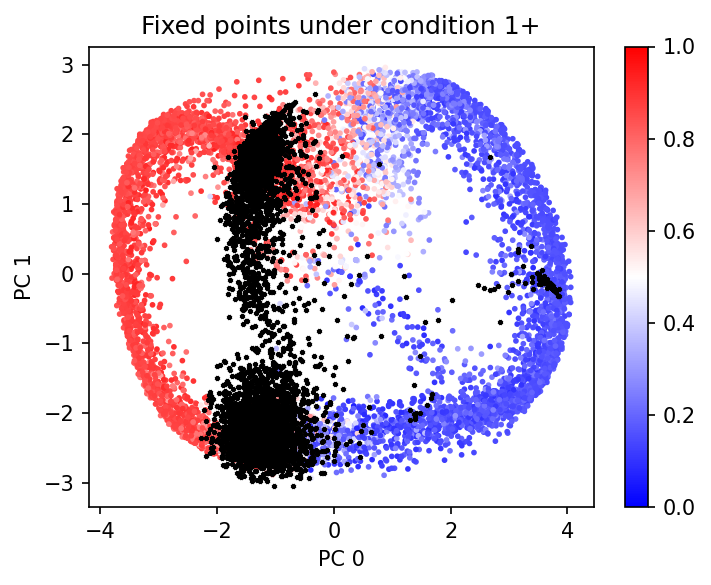

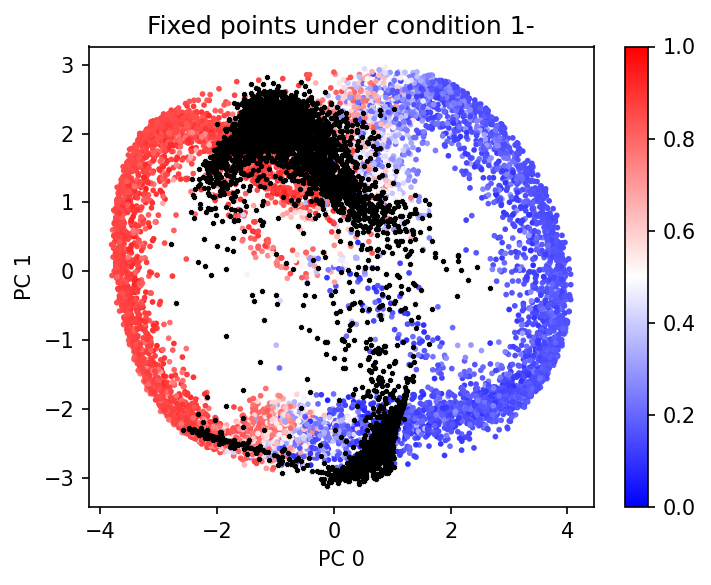

In [37]:
# visualize the fixed points under different input conditions in the PC space

# input condition
# (0,1) labeled 0+
# (0,0) labeled 0-
# (1,1) labeled 1+
# (1,0) labeled 1-

for condition in ['0+', '0-', '1+', '1-']:
    
    # transform fixed points
    fixed_points = fixed_points_per_condition[condition]
    transformed_fixed_points = pca_model_actor.transform(
        fixed_points.reshape(-1, rnn_hidden_dim))

    
    # plot
    fig, ax = plt.subplots(1,1, figsize=(5, 4), dpi=150)
    ax.set_title(f'Fixed points under condition {condition}')
    # plot 0
    pc_x = 0
    pc_y =1
    
    scatter = ax.scatter(
        transformed_actor_hidden_states_training_set[:, :, pc_x],
        transformed_actor_hidden_states_training_set[:, :, pc_y],
        c=a1_probs_training_set, cmap=cm.bwr,
        vmin=0, vmax=1,
        s=3.0
    )
    ax.scatter(
        transformed_fixed_points[:, pc_x],
        transformed_fixed_points[:, pc_y],
        color='k', marker='x', s=3
    )
    ax.set_xlabel(f'PC {pc_x}')
    ax.set_ylabel(f'PC {pc_y}')
    fig.colorbar(scatter, ax=ax)

    fig.tight_layout()



In [77]:
def create_frame(elev, azim, axes_set=[0,1,2], frame=-1, fixed_points=None, condition=None):
    frame = min(frame, np.shape(transformed_actor_hidden_states_testing_set)[1])
    
    fig, ax = plt.subplots(figsize=(10, 8), dpi=150, subplot_kw={'projection': '3d'})
    
    scatter = ax.scatter(
        *[transformed_actor_hidden_states_training_set[:, :, ax] for ax in axes_set],
        s=40.0, c=a1_probs_training_set, cmap=plt.cm.coolwarm,
        vmin=0, vmax=1, alpha=0.2
    )
    
    trajectory = transformed_actor_hidden_states_testing_set[example_session_id, :frame+1]
    ax.plot(*[trajectory[:, ax] for ax in axes_set], color='k', alpha=0.5, linewidth=3)
    
    for tw in range(5):
        frametail = max(frame - tw, 0)
        tail = trajectory[frametail:frame+1]
        ax.plot(*[tail[:, ax] for ax in axes_set], color='k', alpha=0.5, linewidth=10-tw)
    
    current_point = trajectory[frame]
    ax.plot(*[current_point[ax] for ax in axes_set], color='k', marker='o', ms=15, alpha=0.8)
    ax.plot(*[current_point[ax] for ax in axes_set], 
            color=plt.cm.coolwarm(a1_probs_testing_set[example_session_id, frame]), 
            marker='o', ms=10, alpha=0.8)
    
    # Plot fixed points if provided
    if fixed_points is not None:
        fp = fixed_points  # Rename for brevity
        if fp.ndim == 1:  # Single fixed point
            ax.scatter(*[fp[ax] for ax in axes_set], c='k', s=100, marker='.', label='Fixed Point')
            # ax.text(*[fp[ax] for ax in axes_set], 'FP', fontsize=10)
        elif fp.ndim == 2:  # Multiple fixed points
            for i, point in enumerate(fp):
                ax.scatter(*[point[ax] for ax in axes_set], c='k', s=100, marker='.', label=f'FP {i+1}')
                # ax.text(*[point[ax] for ax in axes_set], f'FP {i+1}', fontsize=10)
    
    ax.set_xlabel(f'PC {axes_set[0]}')
    ax.set_ylabel(f'PC {axes_set[1]}')
    ax.set_zlabel(f'PC {axes_set[2]}')
    
    fig.colorbar(scatter, ax=ax, label='Probability of Licking Right')
    
    ax.view_init(elev=elev, azim=azim)
    ax.grid(False)
    
    if condition:
        ax.set_title(f'Condition: {condition}')
    
    fig.tight_layout()
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    
    return buf

def make_mov(n_frames=360, azim_start=60, axes_set=[0,1,2], fixed_points=None, condition=None):
    frames = []
    for i in range(n_frames):
        elev = 30 + 30 * np.sin(2 * np.pi * i / n_frames)
        azim = azim_start + 360 * i / n_frames
        
        buf = create_frame(elev, azim, axes_set=axes_set, frame=i, fixed_points=fixed_points, condition=condition)
        frames.append(imageio.imread(buf))
    
    axes_set_str = '_'.join(map(str, axes_set))
    condition_str = f'_{condition}' if condition else ''

    # Create the filename
    filename = f'rotating_3d_plot_2rotationaxes{axes_set_str}{condition_str}.gif'
    
    # Create the full path including the 'movs' folder
    filepath = os.path.join('movs', filename)

    # Save the GIF
    imageio.mimsave(filepath, frames, fps=5)
    print(f"Saved GIF to {filepath}")

In [ ]:
# Example usage:
for condition in ['0+', '0-', '1+', '1-']:
    
    # transform fixed points
    fixed_points = fixed_points_per_condition[condition]
    transformed_fixed_points = pca_model_actor.transform(
        fixed_points.reshape(-1, rnn_hidden_dim))
    make_mov(n_frames=360, azim_start=60, axes_set=[0,1,2], fixed_points=transformed_fixed_points, condition = condition)

/var/folders/rv/bpj1qnwx5lz32q8rr9jxs07h0000gp/T/ipykernel_29981/1670659961.py:65: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(buf))
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1062d7a50>>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/py311/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
